In [1]:
%matplotlib inline
import numpy
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.ext.protodisk import ProtoPlanetaryDisk
from amuse.ext.composition_methods import *
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.lab import new_powerlaw_mass_distribution
from amuse.plot import scatter
from amuse.community.ph4.interface import ph4
from amuse.community.fi.interface import Fi
from amuse.couple import bridge
# from amuse.community.huayno.interface import Huayno

In [2]:
def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

# def relative_orbital_velocity(distance, mass=SMBH.mass):
#     return (constants.G*mass/distance).sqrt()

def plot():
    plt.figure(figsize=(8,6))
    scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=0.8, c='blue', label='BH')
    scatter(SMBH.x.value_in(units.pc), SMBH.y.value_in(units.pc), s=50, c='r', label='SMBH')
    plt.title("Evolved to t = "+str(model_time.value_in(units.Myr))+" Myr")
    plt.axis('square')
    plt.xlim([-r, r])
    plt.ylim([-r, r])
    

# Distance to (0,0)
def dist(body):
    return (body.x**2+body.y**2+body.z**2).sqrt()

# Define collision detection
def merge_two_stars(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Two BHs", particles_in_encounter.name, particles_in_encounter.mass.in_(units.MSun),
          "collided with d=", d.length().in_(units.au))
    
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].mass = particles_in_encounter.total_mass()
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].position = com_pos
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].velocity = com_vel
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].radius = particles_in_encounter.radius.sum()
    bodies.remove_particle(particles_in_encounter[np.argmin(particles_in_encounter.mass)])
    
#     new_particle=Particles(1)
#     new_particle.mass = particles_in_encounter.total_mass()
#     new_particle.name = particles_in_encounter[np.argmax(particles_in_encounter.mass)].name
#     new_particle.position = com_pos
#     new_particle.velocity = com_vel
#     new_particle.radius = particles_in_encounter.radius.sum()
#     bodies.add_particles(new_particle)
#     bodies.remove_particles(particles_in_encounter)
    
def resolve_collision(collision_detection, gravity, bodies):
    if collision_detection.is_set():
        print("Well, we have an actual collision between two or more BHs.")
        print("This happened at time=", gravity.model_time.in_(units.Myr))
        for ci in range(len(collision_detection.particles(0))): 
            encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
            colliding_BHs = encountering_particles.get_intersecting_subset_in(bodies)
            merge_two_stars(bodies, colliding_BHs)
            bodies.synchronize_to(gravity.particles)

            
            
# Binaries detection
def get_binaries(particles,hardness=0.5,G=constants.G):
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    max_mass=particles.mass.amax()
    limitE=hardness*average_Ek
    
    a=numpy.argsort(particles.x.number)
    a=np.delete(a,particles[a].name=="SMBH")
    n=len(a)

    binaries=[]

    for i in range(0, n-1):
        j=i+1
        while j<n and j<i+10 and (particles.x[a[j]]-particles.x[a[i]])<2*G*max_mass/limitE:
            r2=(particles.x[a[j]]-particles.x[a[i]])**2+ \
               (particles.y[a[j]]-particles.y[a[i]])**2+ \
               (particles.z[a[j]]-particles.z[a[i]])**2 
            v2=(particles.vx[a[j]]-particles.vx[a[i]])**2+ \
               (particles.vy[a[j]]-particles.vy[a[i]])**2+ \
               (particles.vz[a[j]]-particles.vz[a[i]])**2 
            r=r2**0.5
            eb=G*(particles.mass[a[i]]+particles.mass[a[j]])/r-0.5*v2
            if eb > limitE:
                binary=particles[[a[i],a[j]]].copy()
                binary.hardness=eb/average_Ek
                binaries.append(binary)
            j+=1  

    return binaries, average_Ek

## Initial condition

In [3]:
# Start with Sgr A*
SMBH = Particles(1) 
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms
SMBH.radius = 2*constants.G*SMBH.mass/constants.c**2

n_BHs = 300 # Number of stellar-mass BHs
r = 10 # (parsec) The outmost orbital radius of BHs surrounding the SMBH
model_time = 0 | units.Myr

# Make BH disk
def make_BHdisk_around_SMBH(SMBH, n_BHs=n_BHs):
    R = r|units.pc
    Ndisk = n_BHs
    Rin = 0.5
    Rout = 1
    Pinner1 = orbital_period(SMBH.mass, Rin*R)
    converter1 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    masses = new_powerlaw_mass_distribution(Ndisk, 1.0|units.MSun, 100.0|units.MSun, 2.35) # BH masses in powerlaw
    BHdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter1,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=masses.sum()/SMBH.mass).result
    BHdisk.mass = masses
    BHdisk.name = np.arange(1,n_BHs+1).astype("str")
    BHdisk.radius = 2*constants.G*BHdisk.mass/constants.c**2
    BHdisk.remove_attribute_from_store('u')
#     BHdisk.move_to_center()
    return BHdisk, Pinner1, converter1

# Make gas disk
def make_gasdisk_around_SMBH(SMBH):
    R = r|units.pc
    Ndisk = 1000
    Rin = 0.5
    Rout = 1
    Pinner2 = orbital_period(SMBH.mass, Rin*R)
    Mdisk = 1e-3 * SMBH.mass
    converter2 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    
    gasdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter2,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=Mdisk/SMBH.mass).result
    gasdisk.name = "gas disk"
    gasdisk.move_to_center()
    masses = Mdisk/float(Ndisk)
    gasdisk.mass = masses
    rho = 3.0 | (units.g/units.cm**3)
    gasdisk.radius = (gasdisk.mass/(4*rho))**(1./3.)
    return gasdisk, Pinner2, converter2

gasdisk, Pinner2, converter2 = make_gasdisk_around_SMBH(SMBH)
BHdisk, Pinner1, converter1 = make_BHdisk_around_SMBH(SMBH)

# Name each BH
for i in range(n_BHs):
    BHdisk[i].name = "BH"+BHdisk[i].name
    
# Backup
SMBH0, BHdisk0, gasdisk0 = SMBH.copy(), BHdisk.copy(), gasdisk.copy()

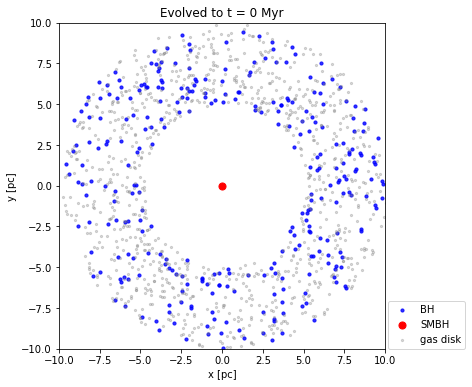

In [4]:
# The initial distribution of our objects
plot()
scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")
plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
plt.show()

## Nbody simulation

In [5]:
gravity = ph4(converter1, number_of_workers=32)
bodies = Particles(0)
bodies.add_particles(BHdisk0)
bodies.add_particles(SMBH0)
SMBH = bodies[bodies.name=="SMBH"]
BHdisk = bodies[bodies.name!="SMBH"]

gravity.particles.add_particles(bodies)
channel = gravity.particles.new_channel_to(bodies)

fig_root = "figure/Nbody/"

Evolved to t = 0 Myr 
BH number = 300
4 Binary found
Binary 1 is ['BH156' 'BH100'] with hardness = 0.65942478689
Binary 2 is ['BH191' 'BH275'] with hardness = 1.52014784135
Binary 3 is ['BH104' 'BH175'] with hardness = 0.571663461354
Binary 4 is ['BH234' 'BH147'] with hardness = 0.510944759273


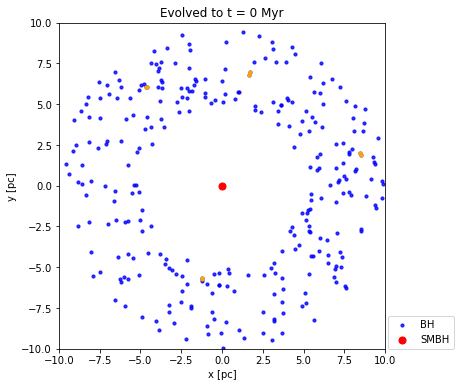



Evolved to t = 1 Myr 
BH number = 300
4 Binary found
Binary 1 is ['BH97' 'BH61'] with hardness = 0.51123196597
Binary 2 is ['BH100' 'BH156'] with hardness = 0.773366545514
Binary 3 is ['BH133' 'BH169'] with hardness = 0.510970334021
Binary 4 is ['BH191' 'BH275'] with hardness = 1.68102280871


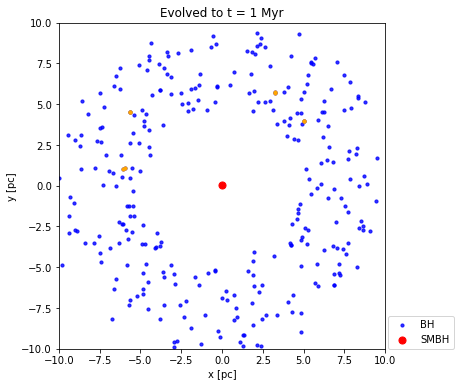



Evolved to t = 2 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH100' 'BH156'] with hardness = 0.7249529149
Binary 2 is ['BH248' 'BH275'] with hardness = 2.3087233611
Binary 3 is ['BH98' 'BH256'] with hardness = 0.50375558242


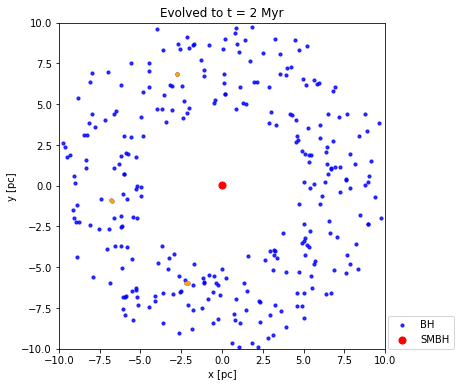



Evolved to t = 3 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH275' 'BH248'] with hardness = 1.89215801866
Binary 2 is ['BH98' 'BH223'] with hardness = 0.632086157932
Binary 3 is ['BH85' 'BH99'] with hardness = 0.640904514492


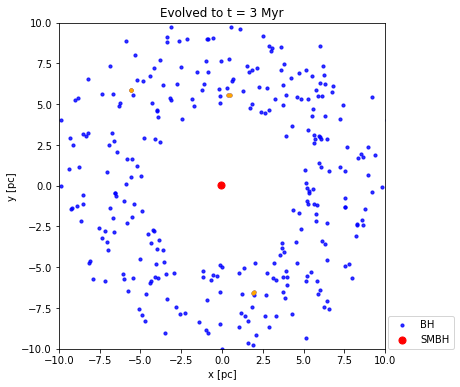



Evolved to t = 4 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH275' 'BH248'] with hardness = 1.90402831513


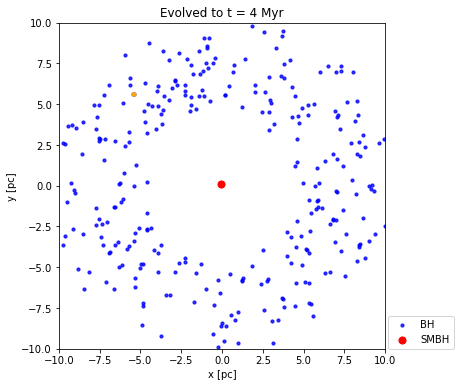



Evolved to t = 5 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH275' 'BH248'] with hardness = 1.87498654366
Binary 2 is ['BH226' 'BH272'] with hardness = 0.649001897037
Binary 3 is ['BH69' 'BH207'] with hardness = 0.534692505033


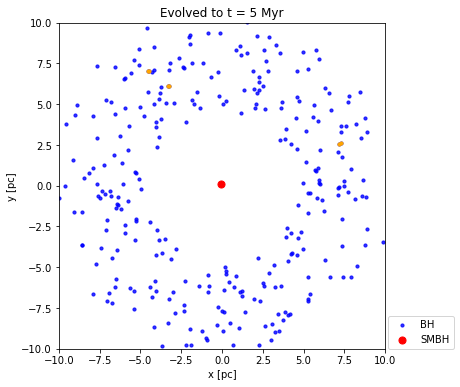



Evolved to t = 6 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH275' 'BH248'] with hardness = 1.59861746483


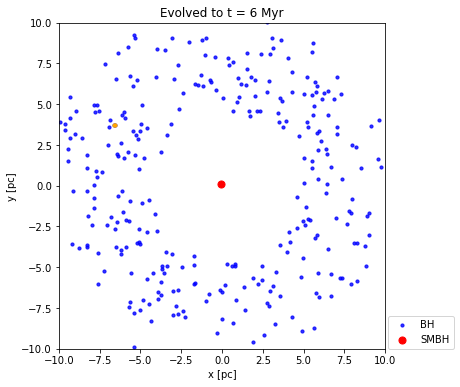



Evolved to t = 7 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH275' 'BH248'] with hardness = 1.58939296379


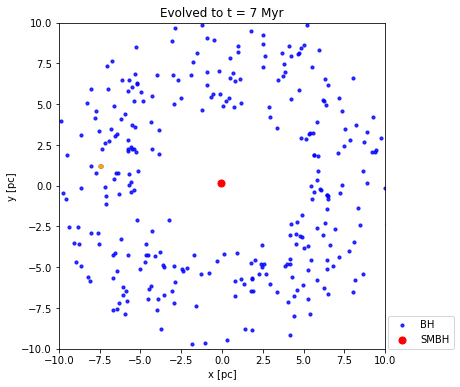



Evolved to t = 8 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH275' 'BH248'] with hardness = 1.62017086253


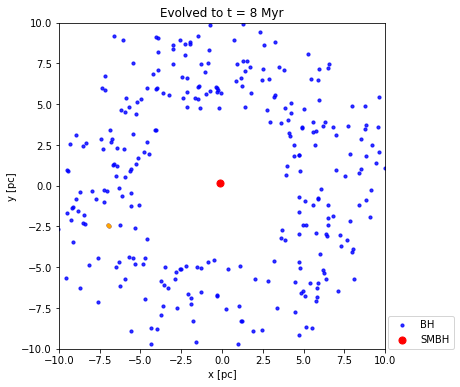



Evolved to t = 9 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH275' 'BH248'] with hardness = 1.64915075624


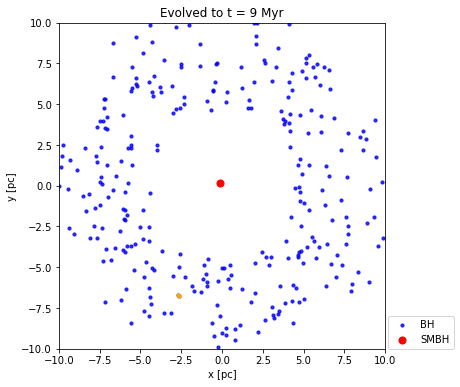

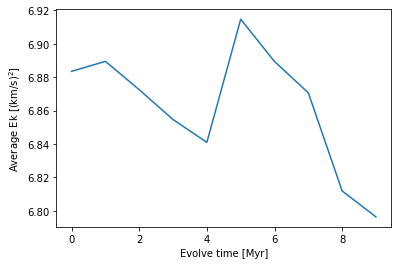

In [6]:
stopping_condition = gravity.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

bodies.radius *= collision_radius_multiplication_factor

end_time = 10 | units.Myr
model_time = 0 | units.Myr
time = [] | units.Myr
dt = 1 | units.Myr
x = 0

evolve_time_list = [] | units.Myr 
average_Ek_list = [] | units.kms**2

while(model_time<end_time):
    
    gravity.evolve_model(model_time)
    resolve_collision(stopping_condition, gravity, bodies)
    channel.copy()
    
    if model_time.value_in(units.Myr)>=x:
        x += 1

        print("Evolved to t =", model_time.in_(units.Myr),
              "\nBH number =", len(BHdisk))

        plot()

        b, average_Ek = get_binaries(bodies)
        
        if(len(b)>0):
            print(len(b), "Binary found")
            
            for i in range(len(b)):
                print("Binary", i+1, "is", b[i].name, "with hardness =", b[i].hardness[0])
                
                if b[i].hardness[0]<10:
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                               [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                               s=10, alpha=1, c='orange')
                else:
                    print("Here we have a hard binary!!!")
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                               [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                               s=10, alpha=1, c='g')  

        
        plt.xlabel("x [pc]")
        plt.ylabel("y [pc]")
        plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
        plt.savefig(fig_root+''+str(model_time.value_in(units.Myr))+'_Myr.png', dpi=200, bbox_inches='tight')
        plt.show()
        
        print("\n")

        evolve_time_list.append(model_time)
        average_Ek_list.append(average_Ek)
        
        
    model_time += dt
    

gravity.stop()

plt.figure()
plt.plot(evolve_time_list.value_in(units.Myr), average_Ek_list.value_in(units.kms**2))
plt.xlabel('Evolve time [Myr]')
plt.ylabel('Average Ek [(km/s)$^2$]')
plt.savefig(fig_root+'average_Ek.png')
plt.show()

## Bridge Nbody with gas disk

In [7]:
bodies = Particles(0)
bodies.add_particles(SMBH0)
bodies.add_particles(BHdisk0)

SMBH = bodies[bodies.name=="SMBH"]
BHdisk = bodies[bodies.name!="SMBH"]

Nbody = SMBH+BHdisk

gravityA = ph4(converter2, number_of_workers=32)
gravityA.particles.add_particles(Nbody)
channel = {"from_BHs": bodies.new_channel_to(gravityA.particles),
            "to_BHs": gravityA.particles.new_channel_to(bodies)}

hydro = Fi(converter2, mode="openmp", workers=32)
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = True
hydro.parameters.integrate_entropy_flag = False
hydro.parameters.timestep = 1e-3*Pinner2 
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
eps = 10 | units.au
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

bodies.add_particles(gasdisk0)
gasdisk = bodies[bodies.name=="gas disk"]

hydro.particles.add_particles(gasdisk)
# hydro.dm_particles.add_particles(SMBH.as_set())
channel.update({"from_gasdisk": gasdisk.new_channel_to(hydro.particles)})
channel.update({"to_gasdisk": hydro.particles.new_channel_to(gasdisk)})
# channel.update({"from_smbh": SMBH.new_channel_to(hydro.dm_particles)})
# channel.update({"to_smbh": hydro.dm_particles.new_channel_to(SMBH)})

fig_root = "figure/Bridge/"

In [8]:
# Bridge gravity and hydro
gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
gravhydro.add_system(gravityA, (hydro,))
gravhydro.add_system(hydro, (gravityA,))

stopping_condition = gravityA.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

Nbody.radius *= collision_radius_multiplication_factor

gravhydro.timestep = 1e-2*Pinner2
print(1e-2*Pinner2.in_(units.yr))

[5138.32874606] 31556925.993600003 * s


Evolved to t = 0 Myr 
BH number = 300
4 Binary found
Binary 1 is ['BH156' 'BH100'] with hardness = 0.65942478689
Binary 2 is ['BH191' 'BH275'] with hardness = 1.52014784135
Binary 3 is ['BH104' 'BH175'] with hardness = 0.571663461354
Binary 4 is ['BH234' 'BH147'] with hardness = 0.510944759273


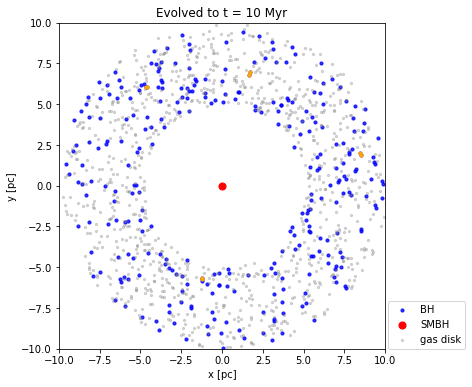



Evolved to t = 1 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH191' 'BH256'] with hardness = 1.04005648082


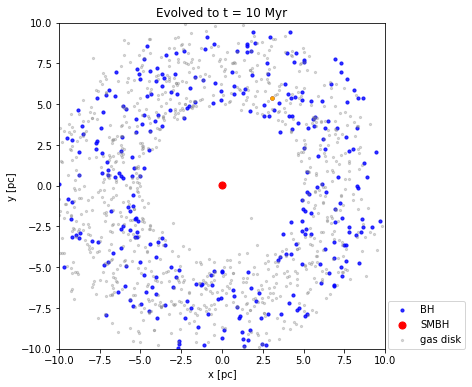



Evolved to t = 2 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH191' 'BH256'] with hardness = 1.03167761867


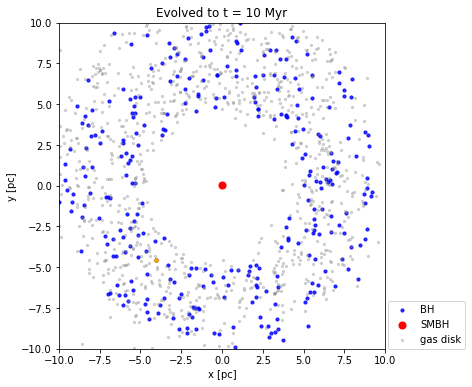



Evolved to t = 3 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH191' 'BH256'] with hardness = 0.996162853631


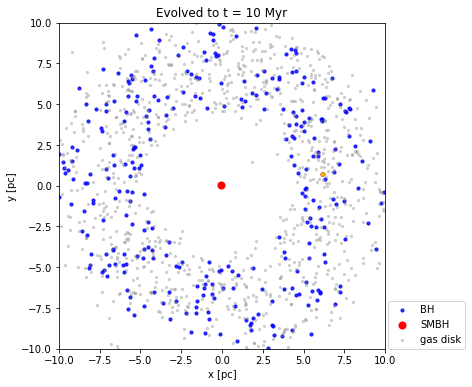



Evolved to t = 4 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH191' 'BH256'] with hardness = 1.01626080248


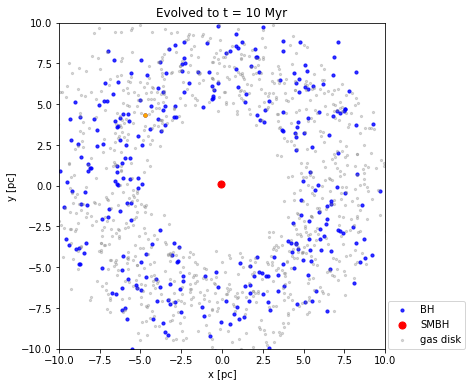



Evolved to t = 5 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH256' 'BH191'] with hardness = 0.845697738774
Binary 2 is ['BH4' 'BH193'] with hardness = 0.63845394674


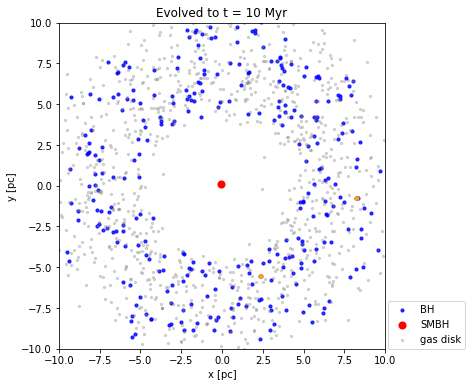



Evolved to t = 6 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH256' 'BH191'] with hardness = 0.854938145784
Binary 2 is ['BH88' 'BH87'] with hardness = 0.539848206804
Binary 3 is ['BH184' 'BH193'] with hardness = 1.57644583563


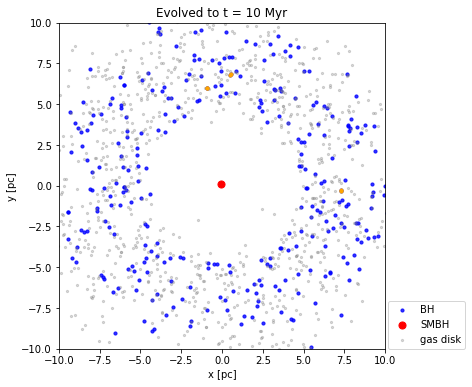



Evolved to t = 7 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH184' 'BH193'] with hardness = 1.64723418979


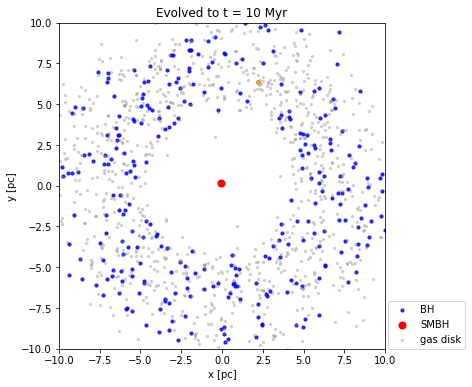



Evolved to t = 8 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH181' 'BH184'] with hardness = 0.600159021317
Binary 2 is ['BH184' 'BH193'] with hardness = 1.78193138122


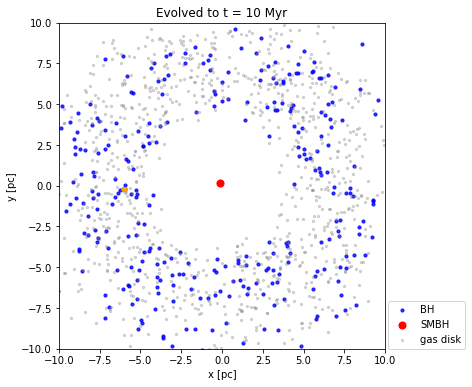



Evolved to t = 9 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH184' 'BH193'] with hardness = 1.3433768916


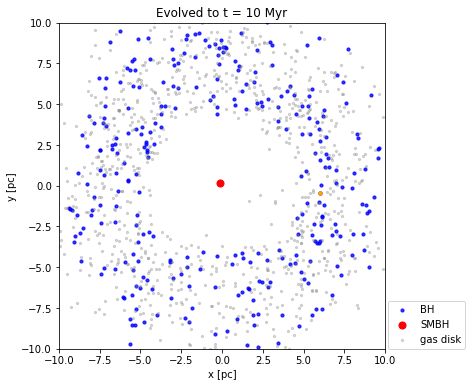

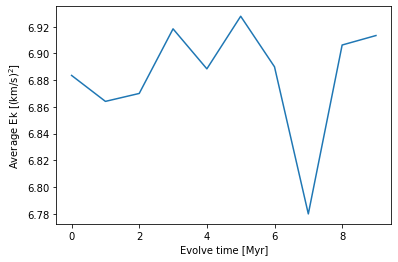

In [9]:
evolve_time_list = [] | units.Myr
average_Ek_list = [] | units.kms**2

def gravity_hydro_bridge(gravityA, hydro, gravhydro, bodies, end_time):
    
    model_time = 0 | units.Myr
    time = [] | units.Myr
    dt = 1 | units.Myr
    x = 0
    
    gravity_initial_total_energy = gravityA.get_total_energy() + hydro.get_total_energy()

    while model_time < end_time:    

        gravhydro.evolve_model(model_time)
        resolve_collision(stopping_condition, gravityA, Nbody)
        
        channel["to_BHs"].copy()
        channel["to_gasdisk"].copy()

        if model_time.value_in(units.Myr)>=x:
            x+=1
            print("Evolved to t =", model_time.in_(units.Myr),
                  "\nBH number =", len(BHdisk))
            
            plot()
            scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
            
            b, average_Ek = get_binaries(Nbody)
        
            if(len(b)>0):
                print(len(b), "Binary found")
            
                for i in range(len(b)):
                    print("Binary", i+1, "is", b[i].name, "with hardness =", b[i].hardness[0])
                
                    if b[i].hardness[0]<10:
                        scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                    [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                    s=10, alpha=1, c='orange')
                    else:
                        print("Here we have a hard binary!!!")
                        scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                    [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                    s=10, alpha=1, c='g') 
                        
            plt.xlabel("x [pc]")
            plt.ylabel("y [pc]")
            plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
            plt.savefig(fig_root+''+str(model_time.value_in(units.Myr))+'_Myr.png', dpi=200, bbox_inches='tight')
            plt.show()
            print("\n")
            
            evolve_time_list.append(model_time)
            average_Ek_list.append(average_Ek)
        
        model_time += dt
        


    gravityA.stop()
    hydro.stop()

# end_time = 10 | units.Myr
gravity_hydro_bridge(gravityA, hydro, gravhydro, 
                     bodies, end_time)

plt.figure()
plt.plot(evolve_time_list.value_in(units.Myr), average_Ek_list.value_in(units.kms**2))
plt.xlabel('Evolve time [Myr]')
plt.ylabel('Average Ek [(km/s)$^2$]')
plt.savefig(fig_root+'average_Ek.png')
plt.show()

In [10]:
# gravhydro.evolve_model(12.035 | units.Myr)

In [11]:
# import matplotlib.animation as animation
# anim = animation.FuncAnimation(fig, update, interval=100)
# plt.show()